In [46]:
import fitz
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import find_peaks

In [2]:
pdf_path = "../data/paganini-caprices.pdf"

In [140]:
pdf_document = fitz.open(pdf_path)
num_pages = pdf_document.page_count
images = []
for page_number in range(num_pages):
    page = pdf_document.load_page(page_number)
    # Use very high DPI to get high quality images
    pix = page.get_pixmap(matrix=fitz.Matrix(400/72, 400/72))

    # Convert to OpenCV format
    img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    images.append(img)

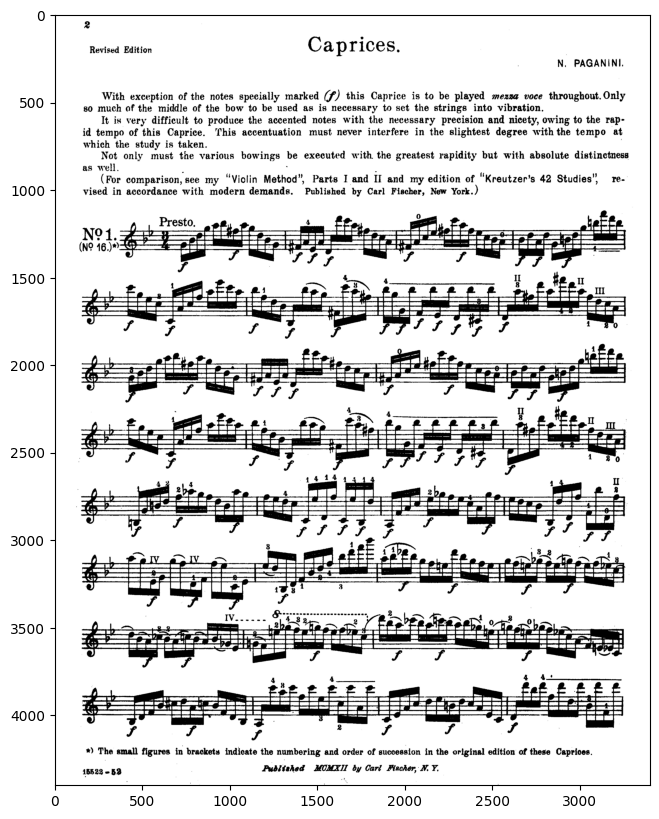

In [141]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0])

In [143]:
def find_troughs(img):
    inverted_img = np.max(img) - img
    troughs, _ = find_peaks(np.sum(inverted_img == 0, axis=1), height=0)

    # Threshold filter
    threshold_value = np.mean(np.sum(inverted_img == 0, axis=1)) + 0.7 * np.std(np.sum(inverted_img == 0, axis=1))
    troughs = troughs[np.sum(inverted_img == 0, axis=1)[troughs] > threshold_value]

    return troughs

def group_peaks_into_staves(peaks, troughs, img):
    staffs = []
    for i, peak in enumerate(peaks[:-1]):
        next_peak = peaks[i + 1]
        trough_indices = [j for j, tr in enumerate(troughs) if peak < tr < next_peak]
        if len(trough_indices) == 1:
            trough = troughs[trough_indices[0]]
            staffs.append((peak, trough, next_peak))
    return staffs

def find_staff_bounds(staffs, troughs):
    bounds = []
    for staff in staffs:
        start_trough_index = np.where(troughs == staff[1])[0][0] - 1
        end_trough_index = np.where(troughs == staff[1])[0][0] + 1
        if start_trough_index >= 0 and end_trough_index < len(troughs):
            bounds.append((troughs[start_trough_index], troughs[end_trough_index]))
    return bounds

def cluster_points(points, max_distance):
    clusters = []
    current_cluster = [points[0]]
    for point in points[1:]:
        if point - current_cluster[-1] <= max_distance:
            current_cluster.append(point)
        else:
            clusters.append(current_cluster)
            current_cluster = [point]
    if current_cluster:
        clusters.append(current_cluster)
    return clusters

def calculate_cluster_centers(clusters):
    return [int(np.mean(cluster)) for cluster in clusters]

def find_staff_bounds_from_troughs(trough_centers):
    staff_bounds = []
    for i in range(len(trough_centers) - 1):
        staff_start = trough_centers[i]
        staff_end = trough_centers[i + 1]
        staff_bounds.append((staff_start, staff_end))
    return staff_bounds

def remove_false_troughs(trough_centers):
    distances = np.diff(trough_centers)  # Calculate distances between consecutive troughs
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    # Identify troughs to remove based on being significantly lower than the mean
    # Here we consider a trough to be an outlier if it's less than half the mean distance
    to_remove = []
    for i, distance in enumerate(distances):
        if distance < mean_distance / 2:
            # Mark the index of the second trough in the pair for removal
            to_remove.append(i + 1)
    
    # Remove the identified troughs
    cleaned_troughs = [tr for i, tr in enumerate(trough_centers) if i not in to_remove]
    return cleaned_troughs

def parse_staves(original_img):
    # Goal: Get coordinates for each staff line

    # convert to black and white
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    _, original_img = cv2.threshold(original_img, 200, 255, cv2.THRESH_BINARY)

    # For each row of the image, get the number of black pixels
    black_pixels = np.sum(original_img == 0, axis=1)

    # Find peaks
    black_pixels = black_pixels.flatten()
    peaks, _ = find_peaks(black_pixels, height=0)

    # Threshold for staves
    threshold_value = np.mean(black_pixels) + 3 * np.std(black_pixels)
    staff_line_peaks = peaks[black_pixels[peaks] > threshold_value]
    staff_line_troughs = find_troughs(original_img)

    # Clustering peaks and troughs into means
    # make max_distance the average distance between staff line peaks
    max_distance = np.mean(np.diff(staff_line_peaks)) / 2
    # peak_clusters = cluster_points(staff_line_peaks, max_distance)
    trough_clusters = cluster_points(staff_line_troughs, max_distance)

    # Calculate cluster centers
    # peak_centers = calculate_cluster_centers(peak_clusters)
    trough_centers = calculate_cluster_centers(trough_clusters)

    # Remove false troughs
    trough_centers = remove_false_troughs(trough_centers)

    # Find staff bounds
    staff_bounds = find_staff_bounds_from_troughs(trough_centers)

    # Plot the histogram with peak_centers and trough_centers
    plt.plot(black_pixels)
    # plt.plot(peak_centers, black_pixels[peak_centers], "x", color='orange')
    plt.plot(trough_centers, black_pixels[trough_centers], "o", color='green')
    for lower, upper in staff_bounds:
        plt.axvline(x=lower, color='green', linestyle='--')
        plt.axvline(x=upper, color='red', linestyle='--')
    plt.show()

    # Split the image into staves
    staves = []
    for lower, upper in staff_bounds:
        staves.append(original_img[lower:upper, ])

    print(f"Found {len(staves)} staves")

    # plot all the staves in a grid
    plt.figure(figsize=(20, 20))
    for i, staff in enumerate(staves):
        plt.subplot(len(staves) // 2 + 1, 2, i + 1)
        plt.imshow(staff, cmap='gray')
    plt.show()

    return staves
    

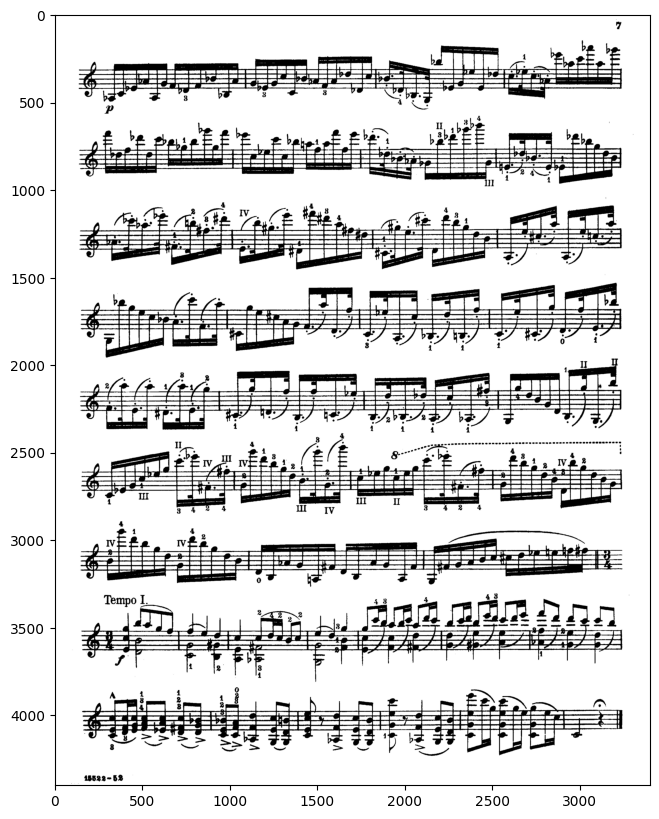

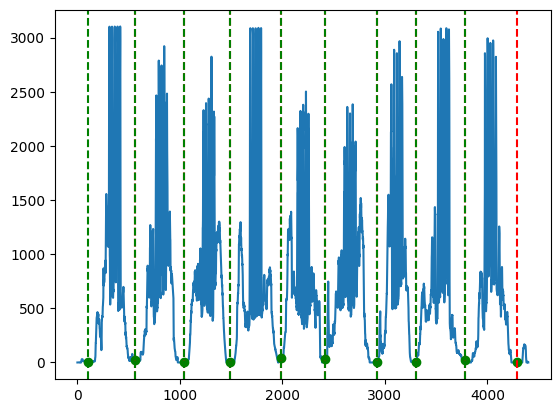

Found 9 staves


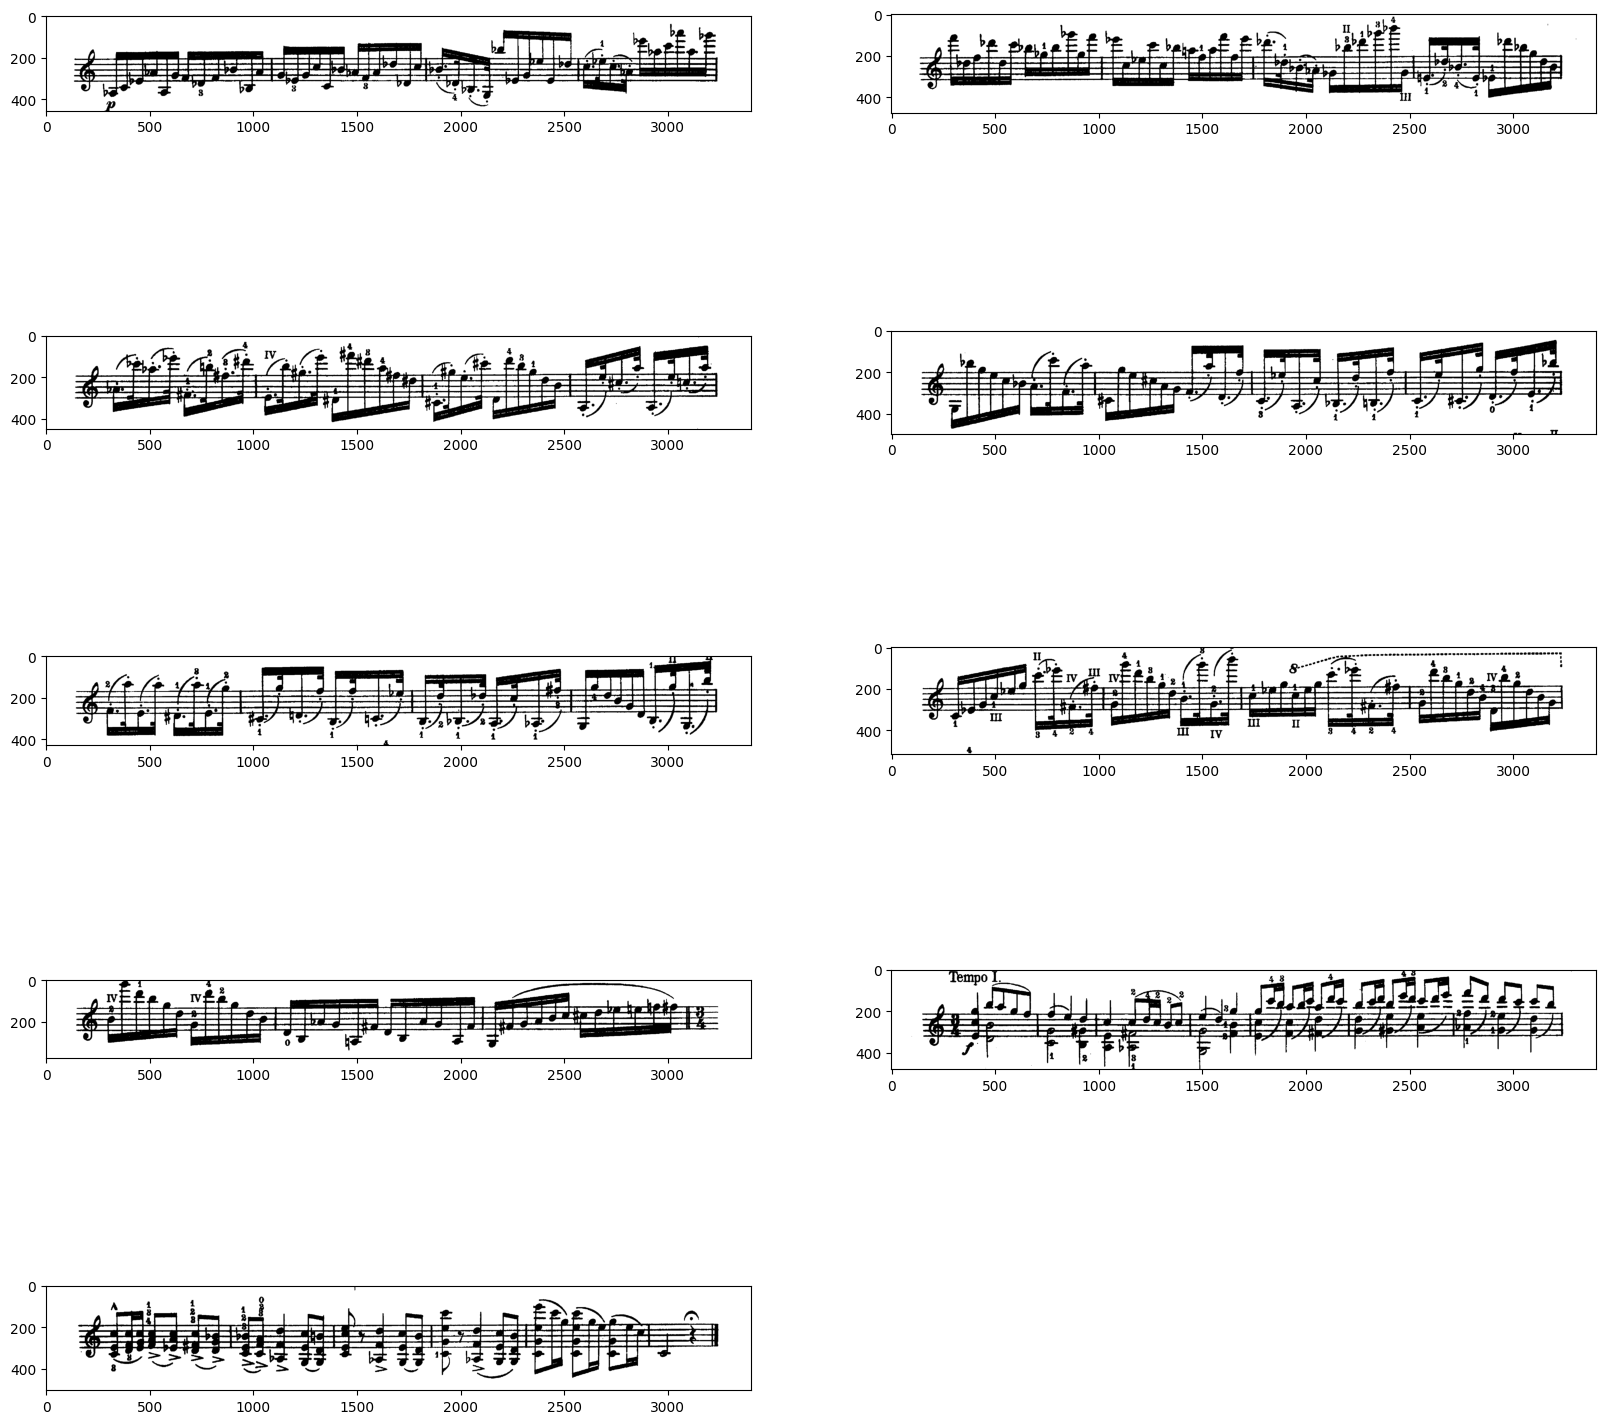

In [145]:
# Plot the original image
plt.figure(figsize=(10, 10))
plt.imshow(images[5], cmap='gray')
plt.show()

staves = parse_staves(images[5])

# plt.figure(figsize=(10, 10))
# plt.imshow(staves[0], cmap='gray')
# plt.show()